In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import json
import pickle as pkl
import numpy as np
import torch_geometric as pyg
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch
import os
import re

os.chdir("..")
print(os.getcwd())

from scripts.utils import *

pd.set_option('future.no_silent_downcasting', True)



/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/dalai/GNN_E


# Create a df with all the movies

In [18]:
dfs = []

dir_path = "/media/RCPNAS/MIP/Michael/ml-students2024/data/fmri414_compiled"
for file in os.listdir(dir_path):
    file_path = os.path.join(dir_path, file)
    print(f"Loading movie {file}...")
    df = pd.read_csv(file_path)
    df["movie"] = re.match(r"^([a-zA-Z]+)_compiled\d+\.csv$", file).group(1)
    dfs.append(df)

movies_df = pd.concat(dfs, ignore_index=True)
movies_df = movies_df.copy()

movies_df

Loading movie AfterTheRain_compiled414.csv...
Loading movie BetweenViewing_compiled414.csv...
Loading movie Rest_compiled414.csv...
Loading movie Sintel_compiled414.csv...
Loading movie BigBuckBunny_compiled414.csv...
Loading movie Payload_compiled414.csv...
Loading movie LessonLearned_compiled414.csv...
Loading movie Superhero_compiled414.csv...
Loading movie TheSecretNumber_compiled414.csv...
Loading movie Spaceman_compiled414.csv...
Loading movie Chatter_compiled414.csv...
Loading movie TearsOfSteel_compiled414.csv...
Loading movie ToClaireFromSonny_compiled414.csv...
Loading movie FirstBite_compiled414.csv...
Loading movie YouAgain_compiled414.csv...


,filename,vindex,full_region,partial_region,score,movie_name,parcel,id,session,movie
0,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-28.029734,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
1,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-28.084551,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
2,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-1.884319,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
3,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-0.738570,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
4,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,48.665913,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
...,...,...,...,...,...,...,...,...,...,...
124589569,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,55.405918,YouAgain,14,sub-S01,ses-1,YouAgain
124589570,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,37.048775,YouAgain,14,sub-S01,ses-1,YouAgain
124589571,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,39.186829,YouAgain,14,sub-S01,ses-1,YouAgain
124589572,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,-25.164869,YouAgain,14,sub-S01,ses-1,YouAgain


# Create df with all the labels

In [29]:
dfs = []

dir_path = "data/raw/labels"
files = os.listdir(dir_path)
files.sort()
for file in files:
    if file.startswith("Annot_13"): #Label of the movie in TR
        file_path = os.path.join(dir_path, file)
        print(f"Loading movie {file}...")
        df = pd.read_csv(file_path, sep="\t", header=None)
        print(df.shape)
        df["movie"] = re.match(r"^Annot_13_([a-zA-Z]+)_stim\.tsv$", file).group(1)
        dfs.append(df)

labels_df = pd.concat(dfs, ignore_index=True)

labels_df

Loading movie Annot_13_AfterTheRain_stim.tsv...
(382, 50)
Loading movie Annot_13_BetweenViewings_stim.tsv...
(622, 50)
Loading movie Annot_13_BigBuckBunny_stim.tsv...
(377, 50)
Loading movie Annot_13_Chatter_stim.tsv...
(312, 50)
Loading movie Annot_13_FirstBite_stim.tsv...
(461, 50)
Loading movie Annot_13_LessonLearned_stim.tsv...
(513, 50)
Loading movie Annot_13_Payload_stim.tsv...
(775, 50)
Loading movie Annot_13_Sintel_stim.tsv...
(555, 50)
Loading movie Annot_13_Spaceman_stim.tsv...
(619, 50)
Loading movie Annot_13_Superhero_stim.tsv...
(791, 50)
Loading movie Annot_13_TearsOfSteel_stim.tsv...
(452, 50)
Loading movie Annot_13_TheSecretNumber_stim.tsv...
(603, 50)
Loading movie Annot_13_ToClaireFromSonny_stim.tsv...
(309, 50)
Loading movie Annot_13_YouAgain_stim.tsv...
(614, 50)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,movie
0,0.142779,0.281039,0.250808,0.330057,-0.341303,-0.076385,1.608596,-0.027852,-0.552002,-0.046603,...,0.380354,-0.154463,-0.041718,-0.652966,0.108885,0.336159,-0.336729,0.276114,-0.135235,AfterTheRain
1,0.015013,0.494496,0.249501,0.452919,-0.385233,0.149844,1.759461,-0.145757,-0.384084,-0.902979,...,0.501055,-0.414479,-0.165635,-1.018303,0.296978,0.325535,-0.252170,0.333992,-0.578877,AfterTheRain
2,0.111895,0.379248,0.301687,0.408731,-0.176680,0.071492,1.389783,-0.254050,-0.434333,-1.026354,...,0.442290,-0.759266,-0.114860,-1.350485,0.218283,0.331140,-0.338974,0.302379,-0.411378,AfterTheRain
3,0.003497,0.436360,0.348070,0.260503,0.043851,0.112154,1.395174,-0.403072,-0.411058,-1.142819,...,0.341601,-0.905446,-0.147157,-1.813156,0.240899,0.326921,-0.250029,-0.498317,-0.506159,AfterTheRain
4,0.047341,0.398398,0.408016,0.029337,0.051369,0.089824,-0.004560,-0.435806,-0.423261,-1.183318,...,-0.037521,-0.805941,-0.123036,-1.928912,0.117960,0.330476,-0.341319,-0.926475,-0.436339,AfterTheRain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,1.512604,1.271192,1.563933,1.263748,2.056116,0.804533,1.999641,-0.251440,1.535576,-0.262581,...,1.137736,-0.190327,0.223826,-0.736421,0.927749,-0.117802,-0.636942,0.506912,-1.066618,YouAgain
7381,1.490208,1.259710,1.746929,1.343119,2.002317,0.792232,1.940891,-0.299603,1.511076,-0.336952,...,1.132471,-0.315264,0.232974,-0.768737,0.912811,-0.122631,-0.642066,0.625236,-1.053043,YouAgain
7382,1.511367,1.286579,1.804114,1.429422,2.069486,0.808375,2.016174,-0.348630,1.543383,-0.358371,...,1.173518,-0.474477,0.244890,-0.854514,0.930434,-0.093923,-0.648708,1.113920,-1.075937,YouAgain
7383,1.615719,1.253187,1.748259,1.432043,1.977821,0.784286,1.910210,-0.336001,1.472017,-0.383722,...,1.138179,-0.432897,0.348575,-0.872797,0.907648,-0.317093,-0.630807,1.194383,-1.045464,YouAgain


In [32]:
# Number of labels for each movie
print(labels_df.groupby(by="movie").size())


movie
AfterTheRain         382
BetweenViewings      622
BigBuckBunny         377
Chatter              312
FirstBite            461
LessonLearned        513
Payload              775
Sintel               555
Spaceman             619
Superhero            791
TearsOfSteel         452
TheSecretNumber      603
ToClaireFromSonny    309
YouAgain             614
dtype: int64


### Make a df with ONLY scores both for 13 or 50 emo

In [33]:
################################
# For 50 emotions
################################
numerical_labels_df_50 = labels_df.drop(columns=["movie"]).copy()

################################
# For 13 emotions
################################

# Remove the "movie" col, only use numerical values
numerical_labels_df_13 = labels_df.drop(columns=["movie"]).copy()

# List of 13 emotiosn to mantain
emo_13_str = [
    'Anger', 'Guilt', 'WarmHeartedness', 'Disgust', 'Happiness',
    'Fear', 'Regard', 'Anxiety', 'Satisfaction', 'Pride',
    'Surprise', 'Love', 'Sad']
emo_13_index = []

# Find to which column each of the 13 emos correpospond
# ATTENTION: suppose the order of the emo is the same for each movie
with open("data/raw/labels/Annot_AfterTheRain_stim.json", 'r') as file:
    data = json.load(file)
    #print(data) 
    #print(data.keys())
    for index, value in enumerate(data["Columns"], start=0):
        #print(f"{index}: {value}")
        if value in emo_13_str:
            emo_13_index.append(index)

emo_13_index

# take only yhe columsn of the relative index
numerical_labels_df_13 = labels_df.iloc[:, emo_13_index].copy()

# Shift back the name of the columns in order to start from 0
numerical_labels_df_13.columns = range(13)

numerical_labels_df_13

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.278402,-0.067563,-0.574943,-0.092547,0.380354,-0.154463,-0.041718,-0.652966,0.108885,0.336159,-0.336729,0.276114,-0.135235
1,0.231400,-0.132726,-0.837308,-0.027584,0.501055,-0.414479,-0.165635,-1.018303,0.296978,0.325535,-0.252170,0.333992,-0.578877
2,-0.158300,-0.114351,-0.820042,-0.013293,0.442290,-0.759266,-0.114860,-1.350485,0.218283,0.331140,-0.338974,0.302379,-0.411378
3,-0.140492,-0.121676,-0.830921,-0.335850,0.341601,-0.905446,-0.147157,-1.813156,0.240899,0.326921,-0.250029,-0.498317,-0.506159
4,-0.153192,-0.118595,-0.822962,-0.606533,-0.037521,-0.805941,-0.123036,-1.928912,0.117960,0.330476,-0.341319,-0.926475,-0.436339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,-0.741717,-0.674364,2.303763,-0.078560,1.137736,-0.190327,0.223826,-0.736421,0.927749,-0.117802,-0.636942,0.506912,-1.066618
7381,-0.744356,-0.654286,2.316243,-0.076406,1.132471,-0.315264,0.232974,-0.768737,0.912811,-0.122631,-0.642066,0.625236,-1.053043
7382,-0.744501,-0.676026,2.473711,-0.082450,1.173518,-0.474477,0.244890,-0.854514,0.930434,-0.093923,-0.648708,1.113920,-1.075937
7383,-0.744234,-0.650470,2.383871,-0.069806,1.138179,-0.432897,0.348575,-0.872797,0.907648,-0.317093,-0.630807,1.194383,-1.045464


### Calculate labels in differt ways

In [34]:
################################
# Method 1: Identify Single Label with Highest Score (by Absolute Value)
################################
# For 50 Emotions
labels_df_50 = labels_df.copy()
labels_df_50["single_label"] = numerical_labels_df_50.abs().idxmax(axis=1)
labels_df_50["max_abs_value"] = labels_df_50.apply(
    lambda row: numerical_labels_df_50.loc[row.name, row["single_label"]], axis=1)
labels_df_50["sign_label"] = np.sign(labels_df_50["max_abs_value"])

# For 13 Emotions 
    #ATTENTION: in this case i have to take only the speific colums
labels_df_13 = numerical_labels_df_13.copy()
labels_df_13["movie"] = labels_df["movie"]
labels_df_13["single_label"] = numerical_labels_df_13.abs().idxmax(axis=1)
labels_df_13["max_abs_value"] = labels_df_13.apply(
    lambda row: numerical_labels_df_13.loc[row.name, row["single_label"]], axis=1)
labels_df_13["sign_label"] = np.sign(labels_df_13["max_abs_value"])

################################
# Method 2: One-Hot Encode Highest Score (by Absolute Value)
################################
# For 50 Emotions
columns_50 = numerical_labels_df_50.columns.tolist()
labels_df_50["single_label_onehot"] = labels_df_50["single_label"].apply(
    lambda label: [1 if col == label else 0 for col in columns_50]
)

# For 13 Emotions
columns_13 = numerical_labels_df_13.columns.tolist()
labels_df_13["single_label_onehot"] = labels_df_13["single_label"].apply(
    lambda label: [1 if col == label else 0 for col in columns_13]
)

################################
# Method 3: Multi-Label One-Hot Encoding Based on Threshold
################################
thr_emo = 1

# For 50 Emotions: Multi-label one-hot encoding with final 'neutrality' flag
labels_df_50["multi_label_onehot"] = numerical_labels_df_50.apply(
    lambda row: [1 if abs(value) > thr_emo else 0 for value in row] + 
                [1 if all(abs(value) <= thr_emo for value in row) else 0],
    axis=1
)

# For 13 Emotions: Multi-label one-hot encoding with final 'neutrality' flag
labels_df_13["multi_label_onehot"] = numerical_labels_df_13.apply(
    lambda row: [1 if abs(value) > thr_emo else 0 for value in row] + 
                [1 if all(abs(value) <= thr_emo for value in row) else 0],
    axis=1
)

# Display the final DataFrames
display(labels_df_50)
display(labels_df_13)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,movie,single_label,max_abs_value,sign_label,single_label_onehot,multi_label_onehot
0,0.142779,0.281039,0.250808,0.330057,-0.341303,-0.076385,1.608596,-0.027852,-0.552002,-0.046603,...,0.336159,-0.336729,0.276114,-0.135235,AfterTheRain,6,1.608596,1.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.015013,0.494496,0.249501,0.452919,-0.385233,0.149844,1.759461,-0.145757,-0.384084,-0.902979,...,0.325535,-0.252170,0.333992,-0.578877,AfterTheRain,6,1.759461,1.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.111895,0.379248,0.301687,0.408731,-0.176680,0.071492,1.389783,-0.254050,-0.434333,-1.026354,...,0.331140,-0.338974,0.302379,-0.411378,AfterTheRain,6,1.389783,1.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,0.003497,0.436360,0.348070,0.260503,0.043851,0.112154,1.395174,-0.403072,-0.411058,-1.142819,...,0.326921,-0.250029,-0.498317,-0.506159,AfterTheRain,44,-1.813156,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,0.047341,0.398398,0.408016,0.029337,0.051369,0.089824,-0.004560,-0.435806,-0.423261,-1.183318,...,0.330476,-0.341319,-0.926475,-0.436339,AfterTheRain,44,-1.928912,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,1.512604,1.271192,1.563933,1.263748,2.056116,0.804533,1.999641,-0.251440,1.535576,-0.262581,...,-0.117802,-0.636942,0.506912,-1.066618,YouAgain,39,2.303763,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, ..."
7381,1.490208,1.259710,1.746929,1.343119,2.002317,0.792232,1.940891,-0.299603,1.511076,-0.336952,...,-0.122631,-0.642066,0.625236,-1.053043,YouAgain,39,2.316243,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, ..."
7382,1.511367,1.286579,1.804114,1.429422,2.069486,0.808375,2.016174,-0.348630,1.543383,-0.358371,...,-0.093923,-0.648708,1.113920,-1.075937,YouAgain,39,2.473711,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, ..."
7383,1.615719,1.253187,1.748259,1.432043,1.977821,0.784286,1.910210,-0.336001,1.472017,-0.383722,...,-0.317093,-0.630807,1.194383,-1.045464,YouAgain,13,2.638797,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, ..."


,0,1,2,3,4,5,6,7,8,9,10,11,12,movie,single_label,max_abs_value,sign_label,single_label_onehot,multi_label_onehot
0,0.278402,-0.067563,-0.574943,-0.092547,0.380354,-0.154463,-0.041718,-0.652966,0.108885,0.336159,-0.336729,0.276114,-0.135235,AfterTheRain,7,-0.652966,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,0.231400,-0.132726,-0.837308,-0.027584,0.501055,-0.414479,-0.165635,-1.018303,0.296978,0.325535,-0.252170,0.333992,-0.578877,AfterTheRain,7,-1.018303,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,-0.158300,-0.114351,-0.820042,-0.013293,0.442290,-0.759266,-0.114860,-1.350485,0.218283,0.331140,-0.338974,0.302379,-0.411378,AfterTheRain,7,-1.350485,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,-0.140492,-0.121676,-0.830921,-0.335850,0.341601,-0.905446,-0.147157,-1.813156,0.240899,0.326921,-0.250029,-0.498317,-0.506159,AfterTheRain,7,-1.813156,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
4,-0.153192,-0.118595,-0.822962,-0.606533,-0.037521,-0.805941,-0.123036,-1.928912,0.117960,0.330476,-0.341319,-0.926475,-0.436339,AfterTheRain,7,-1.928912,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,-0.741717,-0.674364,2.303763,-0.078560,1.137736,-0.190327,0.223826,-0.736421,0.927749,-0.117802,-0.636942,0.506912,-1.066618,YouAgain,2,2.303763,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7381,-0.744356,-0.654286,2.316243,-0.076406,1.132471,-0.315264,0.232974,-0.768737,0.912811,-0.122631,-0.642066,0.625236,-1.053043,YouAgain,2,2.316243,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7382,-0.744501,-0.676026,2.473711,-0.082450,1.173518,-0.474477,0.244890,-0.854514,0.930434,-0.093923,-0.648708,1.113920,-1.075937,YouAgain,2,2.473711,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
7383,-0.744234,-0.650470,2.383871,-0.069806,1.138179,-0.432897,0.348575,-0.872797,0.907648,-0.317093,-0.630807,1.194383,-1.045464,YouAgain,2,2.383871,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]"


In [5]:
# TODO:
# add 3D labels for regression

### Chose the lable type to use (13/50)

In [35]:
n_emo = 13
if n_emo == 13: 
    labels_df = labels_df_13.copy()
else:
    labels_df = labels_df_50.copy()

label_type = "single" #single, singleOneHot, thr
# indepently fo the label type choose use always the same name for the label colum
if label_type == "single":
    labels_df["label"] = labels_df["single_label"]
elif label_type == "singleOneHot":
    pass
elif label_type == "thr":
    label_type = label_type + thr_emo #add the thr used
    pass

labels_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,movie,single_label,max_abs_value,sign_label,single_label_onehot,multi_label_onehot,label
0,0.278402,-0.067563,-0.574943,-0.092547,0.380354,-0.154463,-0.041718,-0.652966,0.108885,0.336159,-0.336729,0.276114,-0.135235,AfterTheRain,7,-0.652966,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",7
1,0.231400,-0.132726,-0.837308,-0.027584,0.501055,-0.414479,-0.165635,-1.018303,0.296978,0.325535,-0.252170,0.333992,-0.578877,AfterTheRain,7,-1.018303,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",7
2,-0.158300,-0.114351,-0.820042,-0.013293,0.442290,-0.759266,-0.114860,-1.350485,0.218283,0.331140,-0.338974,0.302379,-0.411378,AfterTheRain,7,-1.350485,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",7
3,-0.140492,-0.121676,-0.830921,-0.335850,0.341601,-0.905446,-0.147157,-1.813156,0.240899,0.326921,-0.250029,-0.498317,-0.506159,AfterTheRain,7,-1.813156,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",7
4,-0.153192,-0.118595,-0.822962,-0.606533,-0.037521,-0.805941,-0.123036,-1.928912,0.117960,0.330476,-0.341319,-0.926475,-0.436339,AfterTheRain,7,-1.928912,-1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,-0.741717,-0.674364,2.303763,-0.078560,1.137736,-0.190327,0.223826,-0.736421,0.927749,-0.117802,-0.636942,0.506912,-1.066618,YouAgain,2,2.303763,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]",2
7381,-0.744356,-0.654286,2.316243,-0.076406,1.132471,-0.315264,0.232974,-0.768737,0.912811,-0.122631,-0.642066,0.625236,-1.053043,YouAgain,2,2.316243,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]",2
7382,-0.744501,-0.676026,2.473711,-0.082450,1.173518,-0.474477,0.244890,-0.854514,0.930434,-0.093923,-0.648708,1.113920,-1.075937,YouAgain,2,2.473711,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",2
7383,-0.744234,-0.650470,2.383871,-0.069806,1.138179,-0.432897,0.348575,-0.872797,0.907648,-0.317093,-0.630807,1.194383,-1.045464,YouAgain,2,2.383871,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",2


# Load delay file

In [ ]:
# Load onset of different movies, for differt subejcts
#ATTNETION: IN TR!!!
with open("data/raw/labels/run_onsets.pkl", "rb") as file:
    delta_time = pkl.load(file)

delta_time.keys()

dict_keys(['TheSecretNumber', 'ToClaireFromSonny', 'Chatter', 'LessonLearned', 'Payload', 'AfterTheRain', 'Superhero', 'Sintel', 'TearsOfSteel', 'BetweenViewings', 'BigBuckBunny', 'YouAgain', 'Spaceman', 'FirstBite'])

# Add Column with Labels to movie df

In [ ]:
dir_path = "data/raw/movies"
tr_len = 1.3
delay_hrf = 4 #tr
col_label = "label" # nme of the columsn that contians the label to use: type of label to use from df_labels

# list odf dfs with, each one is a movie
dfs_movies = []

for i, file in enumerate(sorted(os.listdir(dir_path))):

    # read csv
    print(f"Creating {file}...")
    file_path = os.path.join(dir_path, file)
    df_movie = pd.read_csv(file_path)

    #add info of the movie
    movie = re.match(r"^([a-zA-Z]+)_compiled\d+\.csv$", file).group(1)
    df_movie["movie_str"] = movie
    df_movie["movie"] = i

    # add timestamp
    df_movie["timestamp_tr"] = df_movie.groupby(["movie_str", "id", "vindex"]).cumcount() #Number each item in each group from 0 to the length of that group - 1.
    df_movie["timestamp_sec"] = df_movie["timestamp_tr"] * tr_len

    # in case for some movies only a subset of subs has seen it
    subjects = df_movie["id"].sort_values().unique()
    subjects = [re.search(r'sub-S(\d+)', id).group(1) for id in subjects if re.search(r'sub-S(\d+)', id)]

    #df with the labels of THIS movie (in TR)
    labels_movie_df = labels_df.loc[labels_df["movie"] == movie, [col_label]]

    # Contains all the df of differt sub of same movie
    dfs_movies_subjects = []


    for sub in subjects:
        print(f"\tAligning subject {sub} for movie {movie}...")

        # put all elemnt of this movie and subjct to -1 (show that we passed here, but still not yet a real label)
        df_movie_sub = df_movie[(df_movie["id"] == f"sub-S{sub}") & (df_movie["movie_str"] == movie)]

        # Ectarct timeshift and duration fir thius sub and this movie
        delta_time_single = delta_time[movie][f"S{sub}"]
        start_movie_sec = delta_time_single[0]
        lenght_movie_sec = delta_time_single[1]
        start_movie_tr = int(start_movie_sec / tr_len)
        lenght_movie_tr = int(lenght_movie_sec / tr_len)
        #print(f"Movie shown at {start_movie_sec} sec. Duration of the movie {lenght_movie_sec} sec.")

        # make the TR index be the same of when the movie begin (NB different for each sub)
        labels_movie_df_copy = labels_movie_df.copy()
        labels_movie_df_copy["timestamp_tr"] = [i for i in range(labels_movie_df.shape[0])] # create  anew col form 0 to len movie  in tr
        labels_movie_df_copy["timestamp_tr"] = labels_movie_df_copy["timestamp_tr"] + start_movie_tr # shift when the movie start
        labels_movie_df_copy["timestamp_tr"] = labels_movie_df_copy["timestamp_tr"] + delay_hrf #shift after for fue to HRF

        df_movie_sub = pd.merge(left = df_movie_sub,
                                right = labels_movie_df_copy,
                                on = "timestamp_tr",
                                how= "left", #A "left" merge means that all rows from df_movie_sub will be retained in the resulting DataFrame, even if there is no matching timestamp_tr in labels_movie_df.
                                ).fillna(-1)  # This fills any NaN values in the result with -1 (remian TR without label)

        #display(df_movie_sub)

        # make id to be int
        df_movie_sub["id"] = int(sub)

        dfs_movies_subjects.append(df_movie_sub)

    movie_df = pd.concat(dfs_movies_subjects, ignore_index=True)

    #display(movie_df[movie_df.full_region == "7Networks_LH_Vis_1"]) #to show only one region and see if the labesl are coreect

    dfs_movies.append(movie_df)

movies_df = pd.concat(dfs_movies, ignore_index=True)

display(movies_df)

# Save mapping mvoies --> int
df_mapping = movies_df[["movie", "movie_str"]].copy()
df_mapping = df_mapping.drop_duplicates()
df_mapping.to_csv('data/raw/labels/category_mapping_movies.csv', index=False)

Creating AfterTheRain_compiled414.csv...
	Aligning subject 01 for movie AfterTheRain...
	Aligning subject 02 for movie AfterTheRain...
	Aligning subject 03 for movie AfterTheRain...
	Aligning subject 04 for movie AfterTheRain...
	Aligning subject 05 for movie AfterTheRain...
	Aligning subject 06 for movie AfterTheRain...
	Aligning subject 07 for movie AfterTheRain...
	Aligning subject 08 for movie AfterTheRain...
	Aligning subject 09 for movie AfterTheRain...
	Aligning subject 10 for movie AfterTheRain...
	Aligning subject 11 for movie AfterTheRain...
	Aligning subject 13 for movie AfterTheRain...
	Aligning subject 14 for movie AfterTheRain...
	Aligning subject 15 for movie AfterTheRain...
	Aligning subject 16 for movie AfterTheRain...
	Aligning subject 17 for movie AfterTheRain...
	Aligning subject 19 for movie AfterTheRain...
	Aligning subject 20 for movie AfterTheRain...
	Aligning subject 21 for movie AfterTheRain...
	Aligning subject 22 for movie AfterTheRain...
	Aligning subject 2

,filename,vindex,full_region,partial_region,score,movie_name,parcel,id,session,movie_str,movie,timestamp_tr,timestamp_sec,label
0,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-21.180140,AfterTheRain,400,1,ses-1,AfterTheRain,0,0,0.0,-1.0
1,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-14.295689,AfterTheRain,400,1,ses-1,AfterTheRain,0,1,1.3,-1.0
2,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-5.882564,AfterTheRain,400,1,ses-1,AfterTheRain,0,2,2.6,-1.0
3,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,30.127113,AfterTheRain,400,1,ses-1,AfterTheRain,0,3,3.9,-1.0
4,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,41.830845,AfterTheRain,400,1,ses-1,AfterTheRain,0,4,5.2,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118876369,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,-21.945122,YouAgain,14,32,ses-1,YouAgain,13,763,991.9,-1.0
118876370,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,3.040432,YouAgain,14,32,ses-1,YouAgain,13,764,993.2,-1.0
118876371,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,-36.525375,YouAgain,14,32,ses-1,YouAgain,13,765,994.5,-1.0
118876372,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,-7.233601,YouAgain,14,32,ses-1,YouAgain,13,766,995.8,-1.0


### Save Memory

In [33]:
movies_df_small = movies_df.copy()

# call the col_label as "label"
movies_df_small = movies_df_small.rename(columns = {col_label : "label"})

# remvoe useless cols<
# only retain columsn for claucltation, then for intepretation we can always do some merge
movies_df_small = movies_df_small.drop(columns=["filename", "parcel" , "session", "timestamp_sec", "movie_name", "full_region", "partial_region", "movie_str"]).copy()

# Spefici type columns to save mepory
movies_df_small['movie'] = movies_df_small['movie'].astype('int8')
movies_df_small['label'] = movies_df_small['label'].astype('int8')
movies_df_small['vindex'] = movies_df_small['vindex'].astype('int16')
movies_df_small['id'] = movies_df_small['id'].astype('int8')  # Convert to category if the values are repetitive
movies_df_small['timestamp_tr'] = movies_df_small['timestamp_tr'].astype('int16')
movies_df_small['score'] = movies_df_small['score'].astype('float32')

movies_df_small

[autoreload of scripts.utils failed: Traceback (most recent call last):
  File "/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/dalai/.conda/envs/gat_gpu/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/dalai/GNN_E/scripts/utils.py", line 184
    def create_feature_label_tensors_for_FNN(df, sizewind=

,vindex,score,id,movie,timestamp_tr,label
0,0,-21.180140,1,0,0,-1
1,0,-14.295689,1,0,1,-1
2,0,-5.882564,1,0,2,-1
3,0,30.127113,1,0,3,-1
4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...
118876369,413,-21.945122,32,13,763,-1
118876370,413,3.040432,32,13,764,-1
118876371,413,-36.525375,32,13,765,-1
118876372,413,-7.233601,32,13,766,-1


In [34]:
# Check meory usage

memory_usage_bytes = movies_df_small.memory_usage(deep=True).sum()
memory_usage_gb = memory_usage_bytes / (1024**3)

print(f"Memory usage: {memory_usage_gb:.4f} GB")


Memory usage: 1.2178 GB


[autoreload of scripts.utils failed: Traceback (most recent call last):
  File "/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/dalai/.conda/envs/gat_gpu/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/dalai/GNN_E/scripts/utils.py", line 218
    X.append(x_matrix)
IndentationError: unexpected indent

# Save final df

In [35]:
# Save df
movies_df_small.to_csv(f"data/processed/all_movies_labelled_{n_emo}_{label_type}.csv")
#movies_df.to_csv('movies_data.csv.zst', index=False, compression='zstd')


# ###################################################à

# Tests and Checks for correct Alignement

In [ ]:
movies_df_loaded = pd.read_csv("data/processed/all_movies_labelled.csv")


movies_df_loaded

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
118876369,118876369,413,-21.945122,32,13,763,-1
118876370,118876370,413,3.040432,32,13,764,-1
118876371,118876371,413,-36.525375,32,13,765,-1
118876372,118876372,413,-7.233601,32,13,766,-1


In [13]:
# let's use after the rain for tets
afterrain = movies_df_loaded[movies_df_loaded.movie == 0]
afterrain

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
6691063,6691063,413,-18.636782,32,0,532,-1
6691064,6691064,413,-53.956333,32,0,533,-1
6691065,6691065,413,-59.845350,32,0,534,-1
6691066,6691066,413,-34.693714,32,0,535,-1


In [14]:
# for a SINGLE TIMEPOINT AND SINGLE SUB the ows hsud eb equal tot th numebr of nodes --> 414
afterrain[(afterrain.timestamp_tr == 0) & (afterrain.id == 1)]

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
534,534,1,-26.000616,1,0,0,-1
1068,1068,2,-75.883064,1,0,0,-1
1602,1602,3,-49.927452,1,0,0,-1
2136,2136,4,-81.747790,1,0,0,-1
...,...,...,...,...,...,...,...
218406,218406,409,-5.679001,1,0,0,-1
218940,218940,410,19.796326,1,0,0,-1
219474,219474,411,-98.217730,1,0,0,-1
220008,220008,412,-54.685820,1,0,0,-1


In [15]:
# for a SINGLE SUB AND SINGLE NODE thE number of timepsoint shodul be the durian of the fmrin in TR
afterrain[(afterrain.vindex == 0) & (afterrain.id == 1)]

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
529,529,0,12.306594,1,0,529,-1
530,530,0,-24.227661,1,0,530,-1
531,531,0,-29.801235,1,0,531,-1
532,532,0,-13.306865,1,0,532,-1


In [16]:
# for a SINGLE SUB AND SINGLE NODE 
# check
    # the TR when the mvoie starts (ie labels != -1)
    # how loin is the duration of the movie (ie TR labelleed)  
afterrain[(afterrain.vindex == 0) & (afterrain.id == 1) & (afterrain.label != -1)]

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
61,61,0,-2.733954,1,0,61,6
62,62,0,-46.140920,1,0,62,6
63,63,0,-5.872955,1,0,63,6
64,64,0,-26.328144,1,0,64,44
65,65,0,-24.370848,1,0,65,44
...,...,...,...,...,...,...,...
438,438,0,-41.126038,1,0,438,49
439,439,0,-15.191757,1,0,439,49
440,440,0,8.831560,1,0,440,49
441,441,0,11.668606,1,0,441,49


In [17]:
# cehck if order of labels is correct
labels_df.loc[labels_df['movie'] == "AfterTheRain", col_label]

5129     6
5130     6
5131     6
5132    44
5133    44
        ..
5506    49
5507    49
5508    49
5509    49
5510    49
Name: single_label, Length: 382, dtype: object

# ##############################################ààààà

# Make Rest compatible with df movies

In [37]:
rest = pd.read_csv("data/raw/rest/Rest_compiled414.csv")

rest_new = rest[["vindex", "score", "id", "movie_name"]] 
rest_new = rest_new.rename(columns={"movie_name": "movie"})
rest_new["timestamp_tr"] = rest_new.groupby(["movie", "id", "vindex"]).cumcount() #Number each item in each group from 0 to the length of that group - 1.
rest_new['id'] = rest_new['id'].str.extract(r'(\d+)', expand=False).astype(int)

# the first 25 and last 25 tr are not usable --> label = -1
# in this way i have some sapce for winodws
border_tr = 25
max_tr = rest_new["timestamp_tr"].unique().max()
rest_new['label'] = 0
rest_new.loc[(rest_new.timestamp_tr <=border_tr) | (rest_new.timestamp_tr > max_tr - border_tr), 'label'] = -1

rest_new['movie'] = 77
rest_new['movie'] = rest_new['movie'].astype('int8')
rest_new['label'] = rest_new['label'].astype('int8')
rest_new['vindex'] = rest_new['vindex'].astype('int16')
rest_new['id'] = rest_new['id'].astype('int8')  # Convert to category if the values are repetitive
rest_new['timestamp_tr'] = rest_new['timestamp_tr'].astype('int16')
rest_new['score'] = rest_new['score'].astype('float32')

display(rest_new)

rest_new.to_csv(f"data/raw/rest/Rest_compiled414_processed.csv")


,vindex,score,id,movie,timestamp_tr,label
0,0,-51.340206,17,77,0,-1
1,0,-22.464891,17,77,1,-1
2,0,-6.034306,17,77,2,-1
3,0,1.782588,17,77,3,-1
4,0,19.611158,17,77,4,-1
...,...,...,...,...,...,...
5713195,413,11.168295,26,77,455,-1
5713196,413,55.019138,26,77,456,-1
5713197,413,-9.323596,26,77,457,-1
5713198,413,-56.129135,26,77,458,-1


# ##############################################ààààà

# Label Statistics

**ATTENTION** as all movies have been seen by all subejcts, we can perform this analysis with only the general labels wihtout multipling each movie for the correct number of subjects.

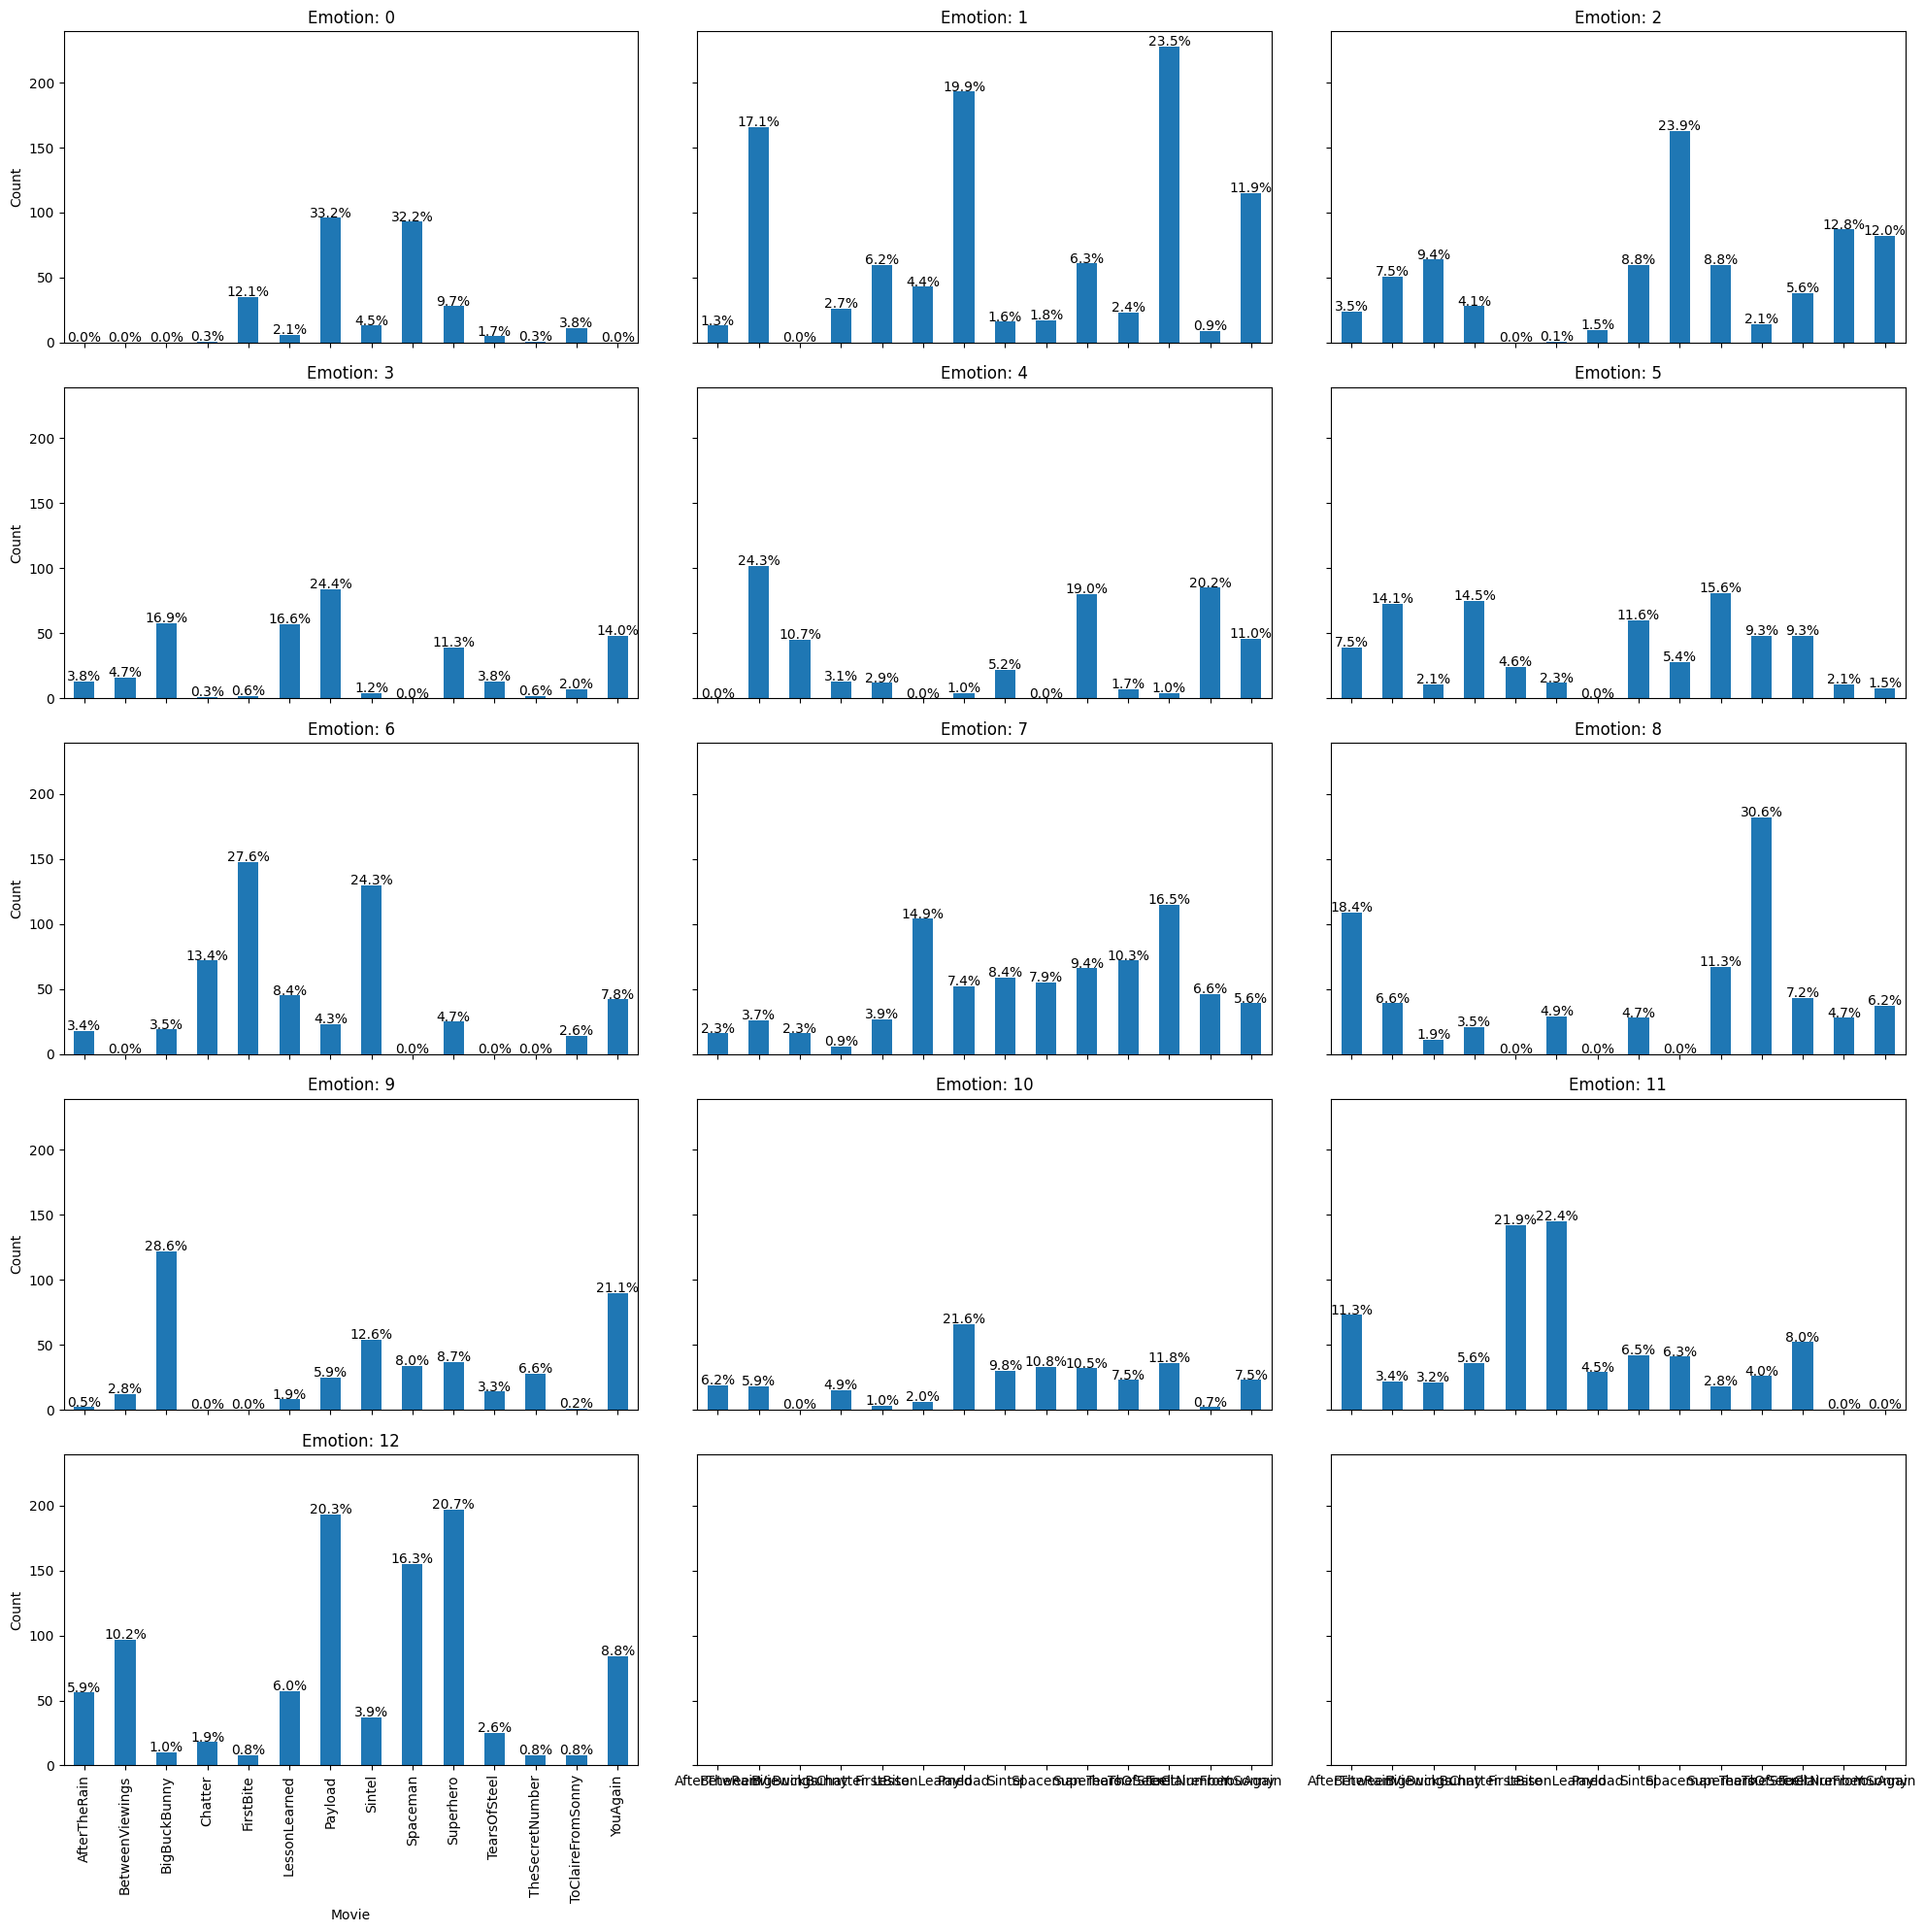

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming labels_df is your DataFrame
# Group by "movie" and "single_label", then count occurrences
grouped = labels_df.groupby(["movie", "single_label"]).size().unstack(fill_value=0)

# Define the number of rows and columns for subplots
n_rows = 5
n_cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True, sharey=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each label and create a plot in the corresponding subplot
for idx, label in enumerate(grouped.columns):
    ax = axes[idx]
    
    # Plot the bar chart for the current label
    grouped[label].plot(kind="bar", ax=ax, title=f"Emotion: {label}", legend=False)
    
    # Add percentages above each bar
    for p in ax.patches:
        height = p.get_height()
        total = sum(p.get_height() for p in ax.patches if p.get_x() == p.get_x())  # total height for this x position
        percentage = (height / total) * 100
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center')

    ax.set_ylabel('Count')
    ax.set_xlabel('Movie')

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


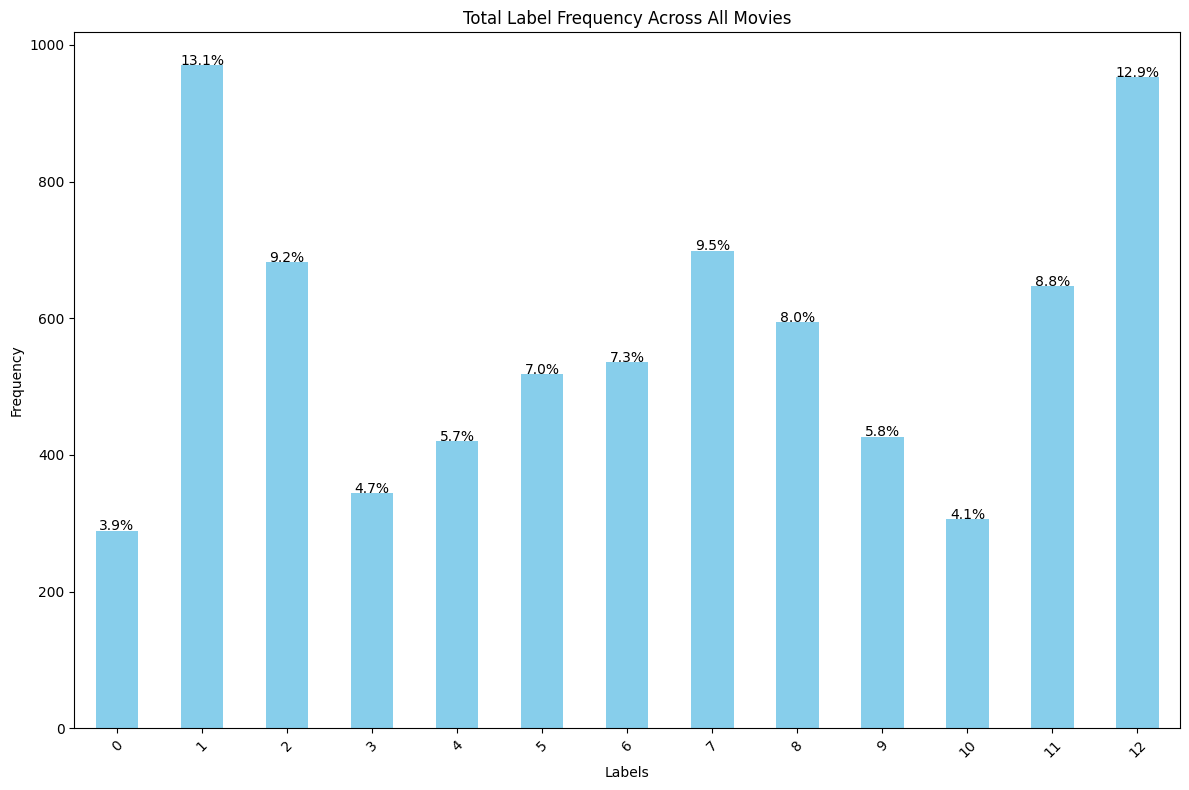

In [11]:
label_totals = labels_df.groupby("single_label").size().reset_index(name="count")

# Create a bar plot showing the frequency of each label across all movies
plt.figure(figsize=(12, 8))
ax = label_totals.plot(kind="bar", x="single_label", y="count", legend=False, color='skyblue', ax=plt.gca())

# Add title and labels
ax.set_title("Total Label Frequency Across All Movies")
ax.set_ylabel("Frequency")
ax.set_xlabel("Labels")

# Add percentages above each bar
total = label_totals["count"].sum()
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

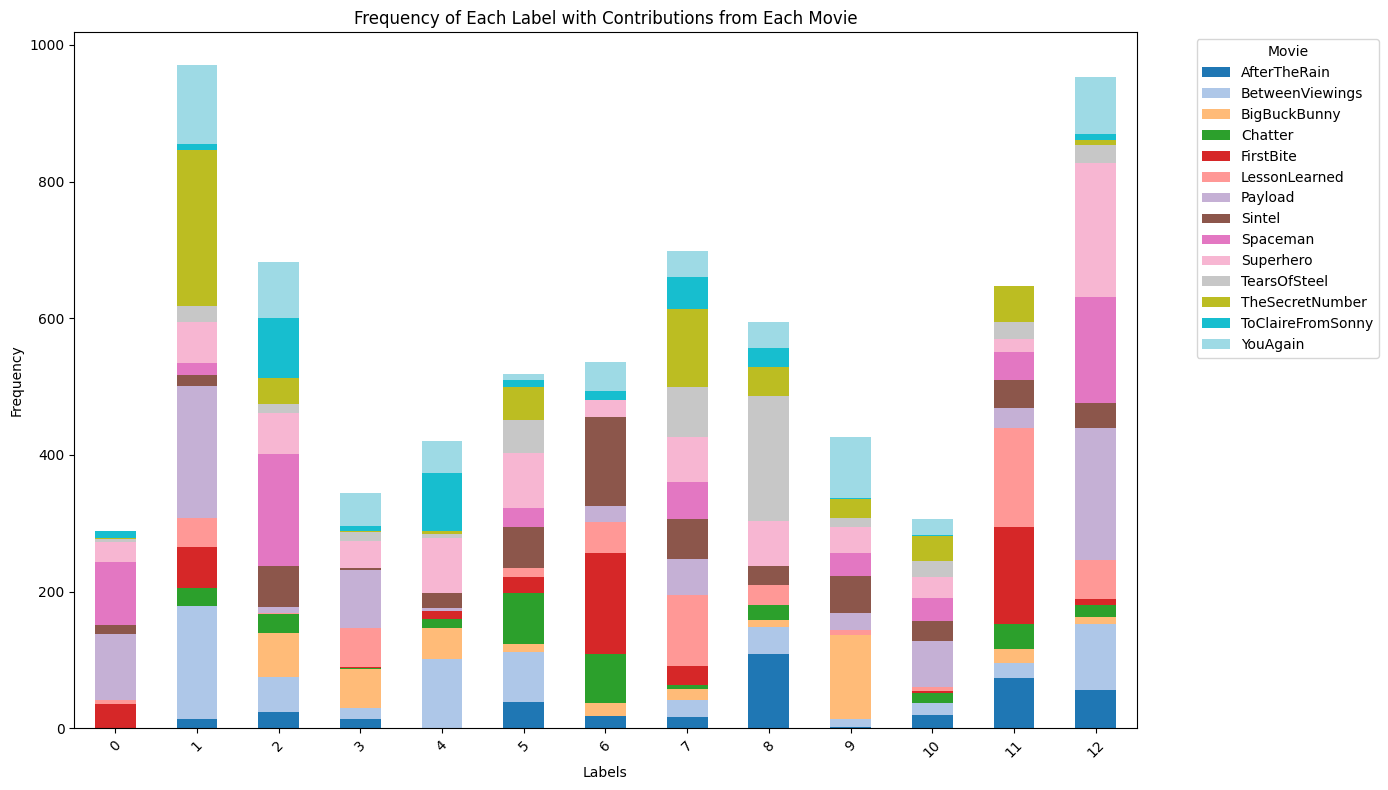

In [12]:
label_counts = labels_df.groupby(["single_label", "movie"]).size().unstack(fill_value=0)

# Plot a stacked bar chart
plt.figure(figsize=(14, 8))
ax = label_counts.plot(kind="bar", stacked=True, ax=plt.gca(), colormap="tab20")

# Set title and labels
ax.set_title("Frequency of Each Label with Contributions from Each Movie")
ax.set_ylabel("Frequency")
ax.set_xlabel("Labels")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add a legend to indicate movie contributions
plt.legend(title="Movie", bbox_to_anchor=(1.05, 1), loc="upper left")

# Display the plot
plt.tight_layout()
plt.show()

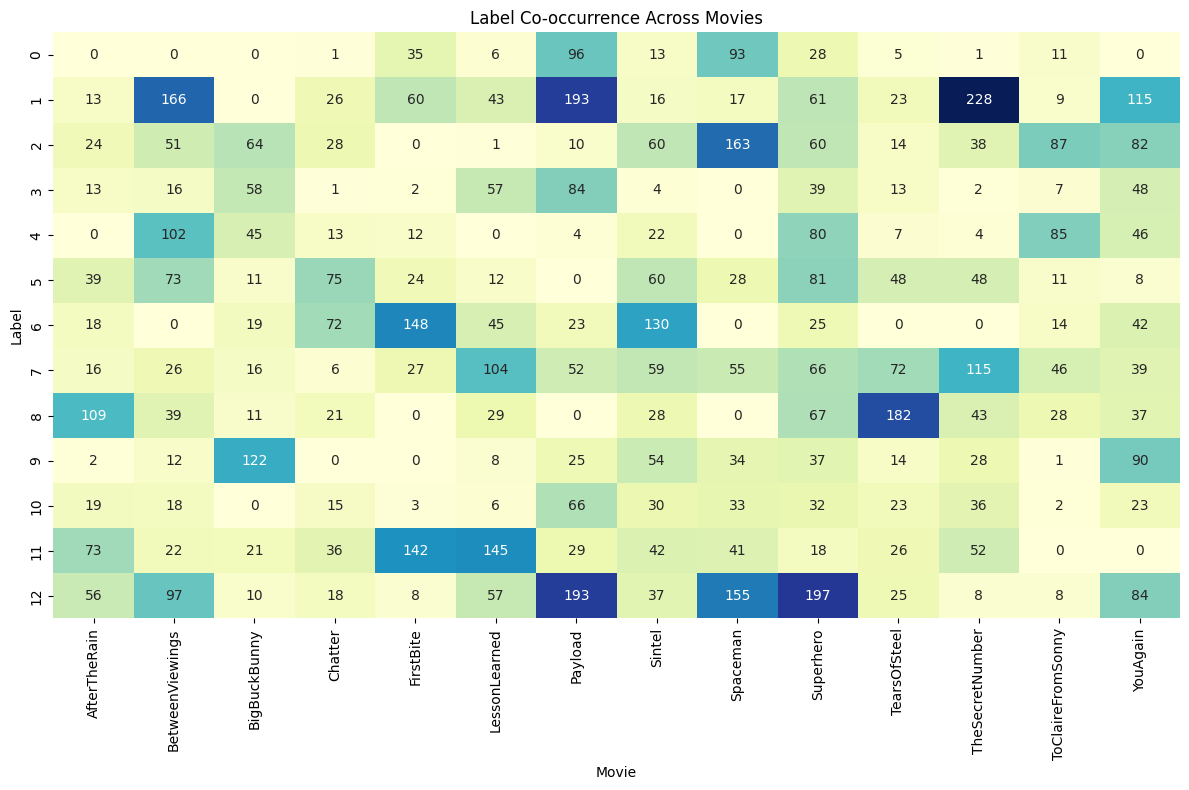

In [14]:
import seaborn as sns

# Create a pivot table of labels vs. movies
label_movie_matrix = labels_df.groupby(['single_label', 'movie']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(label_movie_matrix, cmap='YlGnBu', annot=True, fmt='d', cbar=False)
plt.title('Label Co-occurrence Across Movies')
plt.ylabel('Label')
plt.xlabel('Movie')
plt.tight_layout()
plt.show()

## If splitted Vertically

In [20]:
import pandas as pd
import numpy as np

# Assuming labels_df is your DataFrame with columns "movie" and "single_label"

# Calculate label counts for each movie
label_counts = labels_df.groupby(['movie', 'single_label']).size().unstack(fill_value=0)

# Function to calculate entropy
def calculate_entropy(label_counts):
    # Normalize the label counts to probabilities
    prob = label_counts / label_counts.sum()
    
    # Calculate entropy: H(X) = - sum(p(x) * log(p(x)))
    entropy = -np.sum(prob * np.log(prob + 1e-9))  # Add small constant to avoid log(0)
    
    return entropy

# Calculate entropy for each movie
movie_entropy = label_counts.apply(calculate_entropy, axis=1)

# Sort movies by entropy (ascending: low entropy = homogeneous labels)
sorted_entropy = movie_entropy.sort_values()

# Show movies with the most homogeneous labels (lowest entropy)
print("Movies with most homogeneous labels:")
#print(sorted_entropy.sort_values())


Movies with most homogeneous labels:


In [21]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import entropy

# Assuming labels_df is your dataframe with "movie" and "single_label"
# Get a list of unique movies
movies = labels_df['movie'].unique()

# Create a list to store combinations and their corresponding label distributions
combinations_info = []

# Generate all combinations of three movies
n_in_test = 3
movie_combinations = combinations(movies, n_in_test)

# For each combination of three movies
for combo in movie_combinations:
    # Filter the data for the current combination of movies
    combo_data = labels_df[labels_df['movie'].isin(combo)]
    
    # Calculate the frequency of each label in the combination of movies
    label_counts = combo_data['single_label'].value_counts(normalize=True)
    
    # Calculate the entropy of the label distribution
    label_entropy = entropy(label_counts, base=2)  # Using base 2 for entropy in bits
    
    # Store the combination and its entropy value
    combinations_info.append((combo, label_entropy, label_counts))

# Convert the combinations info into a DataFrame
combo_df = pd.DataFrame(combinations_info, columns=["Combination", "Entropy", "Label Frequencies"])

# Sort the combinations by entropy (lower entropy means more homogeneous distribution)
sorted_combos = combo_df.sort_values(by="Entropy").reset_index(drop=True)

# Get the combination with the most homogeneous label distribution
best_combo = sorted_combos.iloc[-1]
print("Best combination of movies with the most homogeneous label distribution (highest entropy):")
print(best_combo)


Best combination of movies with the most homogeneous label distribution (highest entropy):
Combination                       (BigBuckBunny, Superhero, FirstBite)
Entropy                                                        3.57938
Label Frequencies    single_label
12    0.131983
6     0.117864
11 ...
Name: 363, dtype: object


In [22]:
# with cv
test_movies = ["BigBuckBunny", "Superhero", "FirstBite"]
movie_names = labels_df.movie.unique().tolist()

train_movies = [movie for movie in movie_names if movie not in test_movies]


train_df = labels_df[labels_df['movie'].isin(train_movies)]
test_df = labels_df[labels_df['movie'].isin(test_movies)]

# Calculate the total number of labels in train and test sets
total_train_labels = train_df.shape[0]
total_test_labels = test_df.shape[0]

# Calculate percentage of total labels in train and test
train_percentage = (total_train_labels / (total_train_labels + total_test_labels)) * 100
test_percentage = (total_test_labels / (total_train_labels + total_test_labels)) * 100

# Print the percentages for train and test sets
print(f"Percentage of labels in train set: {train_percentage:.2f}% --> {total_train_labels}")
print(f"Percentage of labels in test set: {test_percentage:.2f} --> {total_test_labels}")

# Calculate and print the percentage of each label in the test set
label_counts_test = test_df['single_label'].value_counts(normalize=True) * 100
#print("\nPercentage of each label in the test set:")
#print(label_counts_test)

label_counts_test = test_df['single_label'].value_counts(normalize=True) * 100


Percentage of labels in train set: 77.94% --> 5756
Percentage of labels in test set: 22.06 --> 1629


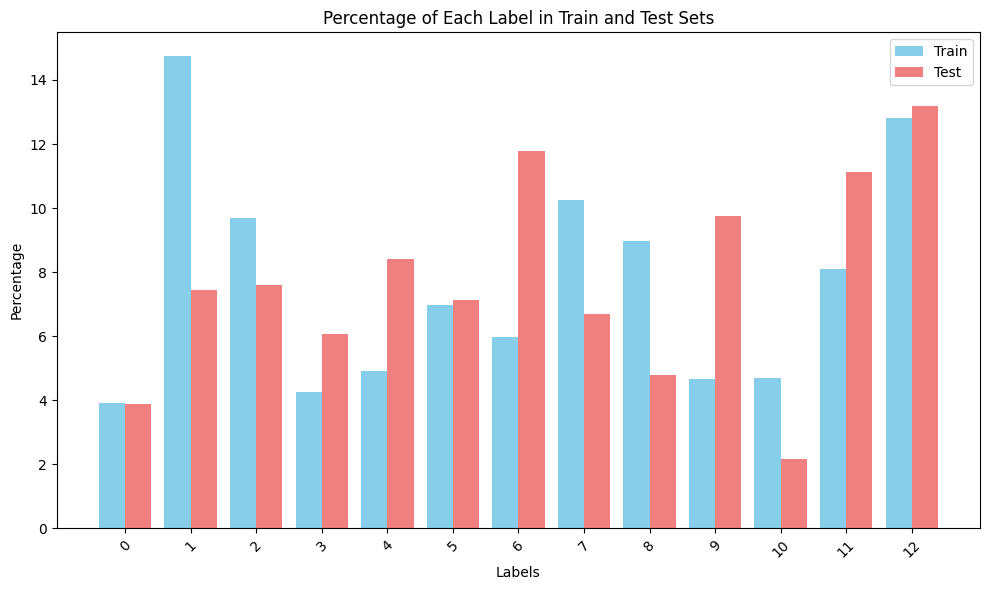

In [23]:
# Filter the dataset to create train and test sets
train_df = labels_df[labels_df['movie'].isin(train_movies)]
test_df = labels_df[labels_df['movie'].isin(test_movies)]

# Calculate percentage of each label in the train and test sets
train_label_counts = train_df['single_label'].value_counts(normalize=True) * 100
test_label_counts = test_df['single_label'].value_counts(normalize=True) * 100

# Get the labels present in both train and test sets
all_labels = set(train_label_counts.index).union(set(test_label_counts.index))

# Ensure all labels are represented in both sets (if absent, assign 0%)
train_label_counts = train_label_counts.reindex(all_labels)#, fillvalue=0)
test_label_counts = test_label_counts.reindex(all_labels)#, fillvalue=0)

# Create a bar plot with two bars side by side for each label
x = range(len(all_labels))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for train and test sets side by side
width = 0.4  # Bar width
ax.bar([i - width/2 for i in x], train_label_counts, width=width, label='Train', color='skyblue')
ax.bar([i + width/2 for i in x], test_label_counts, width=width, label='Test', color='lightcoral')

# Add title and labels
ax.set_title("Percentage of Each Label in Train and Test Sets")
ax.set_xlabel("Labels")
ax.set_ylabel("Percentage")
ax.set_xticks(x)
ax.set_xticklabels(all_labels, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


## If splitted Horizontally

In [ ]:
def split_train_val_test_horizontally(df_all_movies, percentage_train=0.8, percentage_val=0.1, path_pickle_delay="data/raw/labels/run_onsets.pkl", path_movie_title_mapping="data/raw/labels/category_mapping_movies.csv", tr_len=1.3):
    """
    Splits the movie data into train, validation, and test sets based on sequential timing.
    The split is done based on the movie's timeline, ensuring no randomization.

    Args:
    - df_all_movies: DataFrame containing all movie data with timestamps and labels.
    - percentage_train: Proportion of the movie's data to be used for training.
    - percentage_val: Proportion of the movie's data to be used for validation.
    - path_pickle_delay: Path to the pickle file containing the onsets of the movies.
    - path_movie_title_mapping: Path to the CSV file mapping movie titles to numeric ids.
    - tr_len: Length of each time step in seconds (TR length).

    Returns:
    - df_train: DataFrame with updated labels for training data.
    - df_val: DataFrame with updated labels for validation data.
    - df_test: DataFrame with updated labels for test data.
    """
    # Load the onset times for different subjects in different movies
    with open(path_pickle_delay, "rb") as file:
        delta_time = pkl.load(file)

    # Load mapping of movie title to movie ID
    df_movie_mapping = pd.read_csv(path_movie_title_mapping)

    # Create empty DataFrames for train, validation, and test
    df_train = df_all_movies.copy()
    df_val = df_all_movies.copy()
    df_test = df_all_movies.copy()

    # Loop through each movie to perform the sequential split
    movies = df_all_movies["movie"].unique()

    for movie in movies:
        # Retrieve the movie string name
        movie_str = df_movie_mapping[df_movie_mapping.movie == movie]["movie_str"].values[0]
        
        # Access the dictionary of subjects for this movie
        subject_onsets = delta_time[movie_str]
        
        # Assume we are working with the first subject
        first_subject = next(iter(subject_onsets))
        
        # Retrieve the start time and duration of the movie for this subject
        start_movie_sec, length_movie_sec = subject_onsets[first_subject]
        
        # Convert start time and length into time steps (TRs)
        start_movie_tr = int(start_movie_sec / tr_len)
        length_movie_tr = int(length_movie_sec / tr_len)

        # Add delay
        start_movie_tr += 4 #4TR
        
        # Define the splitting points based on the percentages
        end_train_set = start_movie_tr + int(length_movie_tr * percentage_train)
        end_val_set = end_train_set + int(length_movie_tr * percentage_val)

        print(f"\nMovie: {movie_str}")
        print(f"  Start Time (TR)+4: {start_movie_tr}")
        print(f"  Total Length (TR): {length_movie_tr}")
        print(f"  Train End (TR): {end_train_set}")
        print(f"  Validation End (TR): {end_val_set}")
        print(f"  Movie End (TR): {start_movie_tr + length_movie_tr}")
        
        # Train set: Data before the train split point
        df_train.loc[(df_train.movie == movie) & (df_train.timestamp_tr > end_train_set), "label"] = -1
        
        # Validation set: Data between the train and validation split points
        df_val.loc[(df_val.movie == movie) & (df_val.timestamp_tr <= end_train_set), "label"] = -1
        df_val.loc[(df_val.movie == movie) & (df_val.timestamp_tr >= end_val_set), "label"] = -1

        
        # Test set: Data after the validation split point
        df_test.loc[(df_test.movie == movie) & (df_test.timestamp_tr < end_val_set), "label"] = -1

    return df_train, df_val, df_test

In [4]:
df_all_movies = pd.read_csv("data/processed/all_movies_labelled_13_single.csv")

In [14]:
df_rain = df_all_movies[df_all_movies.movie == 0]

df_rain = df_rain[df_rain.vindex == 0]

df_rain = df_rain[df_rain.id == 1]

df_rain = df_rain[df_rain.label != -1]

df_rain

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
61,61,0,-2.733954,1,0,61,7
62,62,0,-46.140920,1,0,62,7
63,63,0,-5.872955,1,0,63,7
64,64,0,-26.328144,1,0,64,7
65,65,0,-24.370848,1,0,65,7
...,...,...,...,...,...,...,...
438,438,0,-41.126038,1,0,438,12
439,439,0,-15.191757,1,0,439,12
440,440,0,8.831560,1,0,440,12
441,441,0,11.668606,1,0,441,12


In [17]:
df_train, df_val, df_test = split_train_val_test_horizontally(
    df_all_movies, 
    percentage_train=0.8, 
    percentage_val=0.2, 
    # what remains is test
    path_pickle_delay="data/raw/labels/run_onsets.pkl", 
    path_movie_title_mapping="data/raw/labels/category_mapping_movies.csv", 
    tr_len=1.3
)


Movie: AfterTheRain
  Start Time (TR): 62
  Total Length (TR): 293
  Train End (TR): 296
  Validation End (TR): 354
  Movie End (TR): 355

Movie: BetweenViewings
  Start Time (TR): 61
  Total Length (TR): 478
  Train End (TR): 443
  Validation End (TR): 538
  Movie End (TR): 539

Movie: BigBuckBunny
  Start Time (TR): 61
  Total Length (TR): 290
  Train End (TR): 293
  Validation End (TR): 351
  Movie End (TR): 351

Movie: Chatter
  Start Time (TR): 61
  Total Length (TR): 240
  Train End (TR): 253
  Validation End (TR): 301
  Movie End (TR): 301

Movie: FirstBite
  Start Time (TR): 61
  Total Length (TR): 354
  Train End (TR): 344
  Validation End (TR): 414
  Movie End (TR): 415

Movie: LessonLearned
  Start Time (TR): 61
  Total Length (TR): 394
  Train End (TR): 376
  Validation End (TR): 454
  Movie End (TR): 455

Movie: Payload
  Start Time (TR): 61
  Total Length (TR): 596
  Train End (TR): 537
  Validation End (TR): 656
  Movie End (TR): 657

Movie: Sintel
  Start Time (TR): 61

In [ ]:
# vindex * movies * subs  
train_labels = (df_train[df_train.label != -1]["label"].value_counts().sort_index() / 414).astype(int)
val_labels = (df_val[df_val.label != -1]["label"].value_counts().sort_index() / 414).astype(int)
test_labels = (df_test[df_test.label != -1]["label"].value_counts().sort_index() / 414).astype(int)
print(train_labels.sum())
print(val_labels.sum())
print(test_labels.sum())

9619
33450
53335


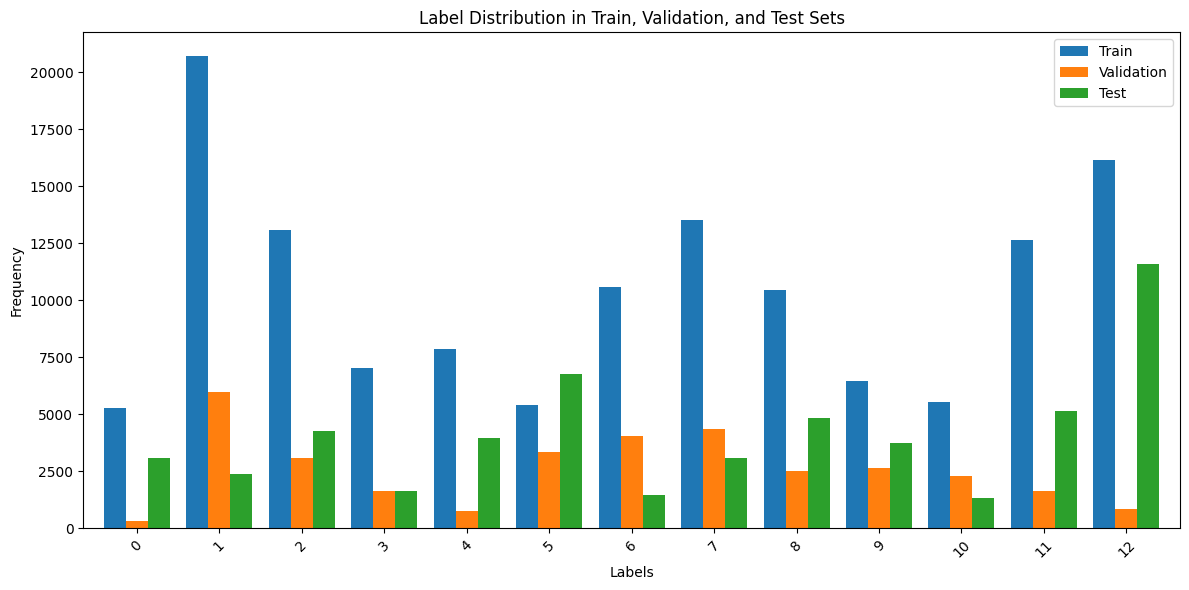

In [62]:
labels = sorted(set(train_labels.index).union(val_labels.index).union(test_labels.index))
label_data = {
    'Train': [train_labels.get(label, 0) for label in labels],
    'Validation': [val_labels.get(label, 0) for label in labels],
    'Test': [test_labels.get(label, 0) for label in labels]
}

# Create a DataFrame
df_labels = pd.DataFrame(label_data, index=labels)

# Plot the grouped bar chart
ax = df_labels.plot(kind='bar', figsize=(12, 6), width=0.8)

# Customize the plot
ax.set_xlabel('Labels')
ax.set_ylabel('Frequency')
ax.set_title('Label Distribution in Train, Validation, and Test Sets')
ax.set_xticklabels(labels, rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# ##############################################ààààà

# Test Create dataset

In [ ]:
from scripts.utils import *

In [18]:
df_all_movies = pd.read_csv("data/processed/all_movies_labelled.csv")

In [28]:
df_rain = df_all_movies[df_all_movies.movie  == 0]
display(df_rain)
dataset = DatasetEmo(df=df_rain)
graphs_list = dataset.get_graphs_list()

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
6691063,6691063,413,-18.636782,32,0,532,-1
6691064,6691064,413,-53.956333,32,0,533,-1
6691065,6691065,413,-59.845350,32,0,534,-1
6691066,6691066,413,-34.693714,32,0,535,-1


Creating the graph 0 1 0/382
Creating the graph 0 1 1/382
Creating the graph 0 1 2/382
Creating the graph 0 1 3/382
Creating the graph 0 1 4/382
Creating the graph 0 1 5/382
Creating the graph 0 1 6/382
Creating the graph 0 1 7/382
Creating the graph 0 1 8/382
Creating the graph 0 1 9/382
Creating the graph 0 1 10/382
Creating the graph 0 1 11/382
Creating the graph 0 1 12/382
Creating the graph 0 1 13/382
Creating the graph 0 1 14/382
Creating the graph 0 1 15/382
Creating the graph 0 1 16/382
Creating the graph 0 1 17/382
Creating the graph 0 1 18/382
Creating the graph 0 1 19/382
Creating the graph 0 1 20/382
Creating the graph 0 1 21/382
Creating the graph 0 1 22/382
Creating the graph 0 1 23/382
Creating the graph 0 1 24/382
Creating the graph 0 1 25/382
Creating the graph 0 1 26/382
Creating the graph 0 1 27/382
Creating the graph 0 1 28/382
Creating the graph 0 1 29/382
Creating the graph 0 1 30/382
Creating the graph 0 1 31/382
Creating the graph 0 1 32/382
Creating the graph 0

In [ ]:
print(graphs_list[0])
loader = pyg.loader.DataLoader(graphs_list, batch_size=32, num_workers=4, persistent_workers=True)

first_batch = next(iter(loader))
print(first_batch)
# Attention
    # when you batch multiple graphs, the node features and edge indices of the individual graphs are concatenated into a single large batch
    #batch=[13248]: This is a batch vector that indicates to which graph each node belongs. 
    #The ptr tensor helps define the boundaries of each graph. For example, if ptr[i] = 10 and ptr[i+1] = 20, that means the nodes from index 10 to 19 belong to the i-th graph

Data(x=[414, 1], edge_index=[2, 170982], edge_attr=[170982, 1], y=6)
DataBatch(x=[13248, 1], edge_index=[2, 5471424], edge_attr=[5471424, 1], y=[32], batch=[13248], ptr=[33])
